# Imports

In [ ]:
!pip install statsmodels==0.12.1
!pip install pmdarima
!pip install simple-colors
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/DUQ_hourly.csv

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import pmdarima as pm
from numpy import fft
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from simple_colors import *

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
sns.set_style('darkgrid')
%matplotlib inline

# Functions

In [ ]:
# Function for plotting categorical features
def plot_cat(df, col, target):
  for c in col:
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxplot(x = c, y = target, data = df, orient = 'v')
    ax.set_title(f'{c} vs target')

In [ ]:
# Function for splitting the data
def split_data(df, trg, split):
  tr, ts = df.loc[df.index.year < split], df.loc[df.index.year >= split]
  tr_X, tr_y = tr.drop(f'{trg}', axis = 1), tr[f'{trg}']
  ts_X, ts_y = ts.drop(f'{trg}', axis = 1), ts[f'{trg}']
  return tr_X, tr_y, ts_X, ts_y

In [ ]:
# Function for calculating MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Function for forecast estimation
def est(ts_y, pred_y):
  mape = mean_absolute_percentage_error(ts_y, pred_y)
  mae = mean_absolute_error(ts_y, pred_y)
  print(red('MAE = ', ['bold']), mae)
  print(red('MAPE = ', ['bold']), mape)

In [ ]:
# Function for cross-validation with MAE
def CV(model, X, y, cv):
    fitted = model.fit(X,y)
    CV_score = np.mean(np.abs(cross_val_score(estimator = fitted, X = X, y = y, cv = cv, scoring='neg_mean_absolute_error')))
    print(blue('Mean CV score: ', ['bold']), CV_score)

In [ ]:
# Function for fitting and estimating model
def fit_est_model(model, tr_X, tr_y, ts_X, ts_y, cv):
  model.fit(tr_X, tr_y)
  y_pred = model.predict(ts_X)
  res = ts_y - y_pred
  est(ts_y, y_pred)
  CV(model, ts_X, ts_y, cv)
  return y_pred, res

In [ ]:
# Function for plotting model's results
def plot_model(y_pred, ts_y, title):
  plt.figure(figsize=(20, 7))
  plt.plot(y_pred, "g", label="prediction", linewidth=2.0)
  plt.plot(ts_y.values, label="actual", linewidth=2.0)
  plt.legend(loc='best', fontsize=20)
  plt.title(f'{title} predictions vs actual', fontsize=20);

In [ ]:
# Function for residual analysis
def residual_analysis(errors, pred):

  # Perform the Ljung-Box test
  lb_test = acorr_ljungbox(errors , lags = 4)
  print(red('P-values for Ljung-Box test are:\n ', ['bold']), lb_test[1])

  plt.rcParams['figure.figsize'] = (10, 7)

  plt.scatter(list(range(len(errors))),errors);
  plt.title("Distibution of errors")
  plt.ylabel('Error');
  plt.xlabel('Index');
  plt.show();

  plt.scatter(pred,errors);
  plt.title('Relationship of true value vs error (residual analysis)')
  plt.ylabel('Error');
  plt.xlabel('True value');
  plt.show();

  # Generate ACF plot of the residuals
  plot_acf(errors, alpha = 0.05)
  plt.show()

In [ ]:
# Function for plotting feature importance by .coef_
def plot_importance(est, colnames, title, top_n=30):
    importance = pd.DataFrame({
        'Weight': np.abs(est.coef_),
        'Features': colnames})
    imp20 = importance.sort_values(by='Weight', ascending=False)[:top_n]
    plt.figure(figsize=(12, 7))
    sns.barplot(y='Features', x='Weight', data=imp20, orient='h')
    plt.title(f'Feature importance for {title}')

In [ ]:
# Function for plotting feature importance by .feature_importance_
def plot_importance_lg(est, colnames, title, top_n=30):
    importance = pd.DataFrame({
        'Weight': np.abs(est.feature_importances_),
        'Features': colnames})
    imp20 = importance.sort_values(by='Weight', ascending=False)[:top_n]
    plt.figure(figsize=(12, 7))
    sns.barplot(y='Features', x='Weight', data=imp20, orient='h')
    plt.title(f'Feature importance for {title}')

In [ ]:
# Function for forecast estimation
def est_pr(ts_y, pred_y, mape=True):
  r2 = r2_score(ts_y, pred_y)
  mae = mean_absolute_error(ts_y, pred_y)
  print(red('MAE = ', ['bold']), mae)
  print(red('R2 = ', ['bold']), r2)

In [ ]:
# Function for testing stationarity
def test_stationarity(timeseries, n, data, split):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=n).mean()
    rolstd = pd.Series(timeseries).rolling(window=n).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 9))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print(red('\nResults of Dickey-Fuller Test:', ['bold']))
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    #Perform KPSS test
    print (red('\nResults of KPSS Test:', ['bold']))
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:2], index=['Test Statistic','p-value'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

    # Statistics for 2 different parts of data
    X1, X2 = data.loc[data.index.year < split]['DUQ_MW'], data.loc[data.index.year >= split]['DUQ_MW']
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print (red('\nStatistics for 2 parts od data:', ['bold']))
    print('\n----------------------------------------------------')
    print('mean1=%f\nmean2=%f\n' % (mean1, mean2))
    print('variance1=%f\nvariance2=%f' % (var1, var2))
    print('\n----------------------------------------------------')

# Data preparation and initial EDA

Description: Datset is estimated hourly power consumption in Megawatts (MW) from Duquesne Light Co

In [ ]:
# Reading the data
data = pd.read_csv('DUQ_hourly.csv', index_col=["Datetime"], parse_dates=["Datetime"])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DUQ_MW  119068 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [ ]:
# Checking for missing values
data.isna().sum()

DUQ_MW    0
dtype: int64

So we don't have any missing values and also we have for some years only 1 month of data, so those 2 months will be cutted as we have enough data within whole years

In [ ]:
# Cutting the data to have whole years in dataset
data = data.loc[data.index.year < 2018]
data = data.loc[data.index.year >= 2006]

In [ ]:
# Checking for duplicated datetime indexes
indx_dupl = data.index.duplicated()
indx_dupl = np.where(indx_dupl == True)
to_drop = list(indx_dupl[0])
to_drop

[71530, 80314, 88954, 97761]

In [ ]:
# Dropping duplicated indexes
data.drop(data.index[to_drop], inplace=True)

In [ ]:
# Finding the indexes which has not 1 hour difference
list_of_indx = []
for i in range(0, len(data)-1):
  t1 = pd.to_datetime(data.index[i])
  t2 = pd.to_datetime(data.index[i+1])
  diff = pd.Timedelta(t2 - t1).seconds /3600
  if diff!=1:
    list_of_indx.append([i, diff])

print('Length of differences: ', len(list_of_indx))
list_of_indx = pd.DataFrame(list_of_indx)
list_of_indx[1].unique() # unique values of hours difference


Length of differences:  26


array([2.])

So we have only 26 missing timestamps because all hour differences = 2. It is very small number regarding total dataset. Will be interpolated via rolling window later.

## Target

First let's take a look on target visualization

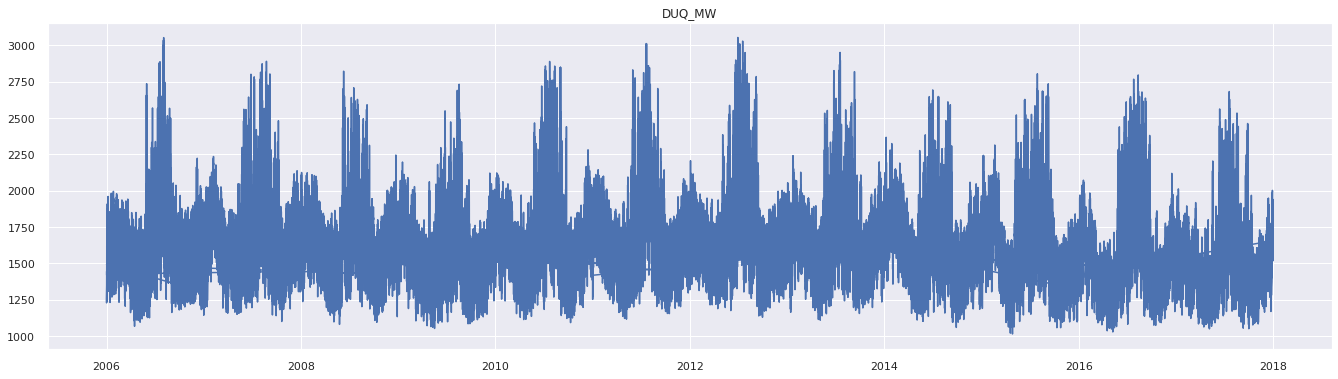

In [ ]:
# Visualization for target
plt.figure(figsize=(23, 6))
plt.plot(data.DUQ_MW)
plt.title('DUQ_MW');

From this plot it seems like there is some seasonality peak in the middle of every year, may be there is quarter or year seasonality, but it will be explored in more details in next section

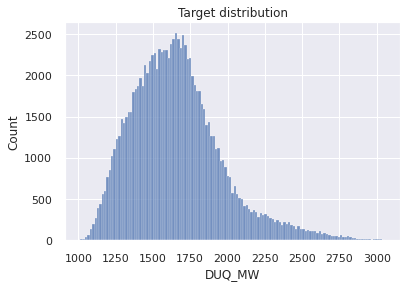

In [ ]:
# Visualization for target distribution
sns.histplot(data=data, x='DUQ_MW')
plt.title('Target distribution');

Target distribution is close to normal, log transformation will be checked

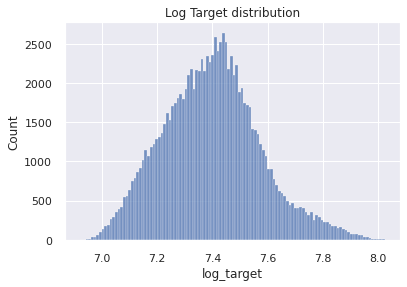

In [ ]:
# Visualization for target distribution with log transformation
data['log_target'] = np.log(data.DUQ_MW)
sns.histplot(data=data, x='log_target')
plt.title('Log Target distribution');
data.drop('log_target', axis=1, inplace=True)

As we can see from the histogram log transformation works good, distribution became more close to normal and scale of data is much smaller. But for now log transformation will not be applied as we have absolute number of MAE in the task, so only after achieving <140 value log transformation will be used to check how it works in the model.

## Autocorrelation

First we can check autocorrelation of our data and it can help to discover some seasonality or trend

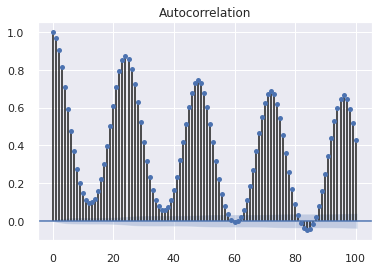

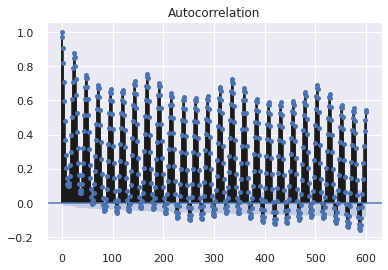

In [ ]:
# Autocorrelation plots (ACF) for data with 100 and 600 legs
plot_acf(data.DUQ_MW, lags=100)
plot_acf(data.DUQ_MW, lags=600)
plt.show()

* From the first ACF plot we can see that our seasonal period consists of 25 timesteps (where the ACF has the second largest positive peak), and for the second ACF it is roughly 170 timesteps.
* Actually it corresponds to the daily and weelky seasonality, which is probably exists, will be checked in more details in next section


# Forecast with raw data

* Initially in our task we need to forecast with raw data and time feature only.

* I've tried first to do forecasting on raw data with Naive, Moving Avarage and Holt Winter approach.

* Then I'll add time feature(hour) and check Linear Regression as baseline. After that some improvements will be done and other models used.

* For metrics MAE is requered in the task but also I'll check MAPE as relative metric for different scales.

* Test split need to be done for last year in our dataset



In [ ]:
# Splitting test and train data into last year and all others
train, test = data.loc[data.index.year < 2017], data.loc[data.index.year >= 2017]

## Naive

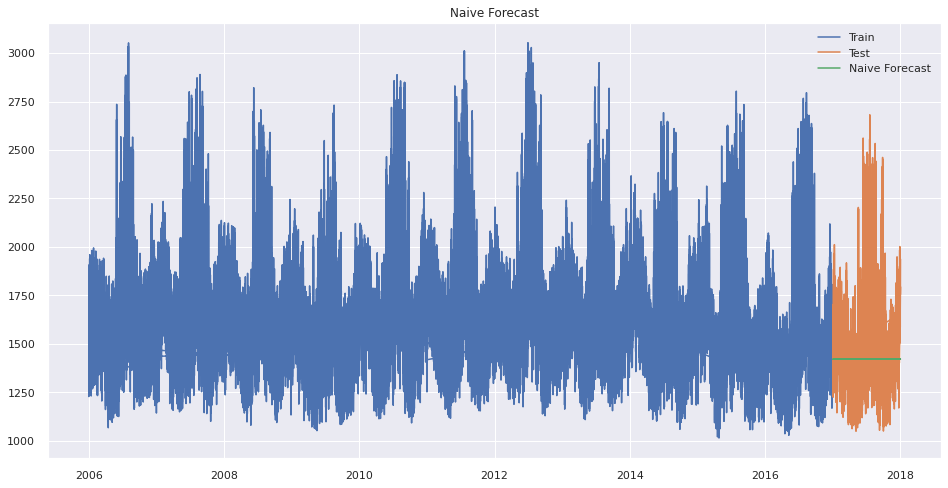

In [ ]:
# Visualization for Naive Forecast
dd= np.asarray(train.DUQ_MW)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(16,8))
plt.plot(train.index, train.DUQ_MW, label='Train')
plt.plot(test.index, test.DUQ_MW, label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

As we can see our data has big variance and naive approach doesn't work good

In [ ]:
# Estimating naive forecasting
est(test.DUQ_MW, y_hat.naive)

MAE =  218.1649920073076
MAPE =  13.224763806247777


And metrics show the same, MAE is big and forecasting is not accurate

## Moving Avarage

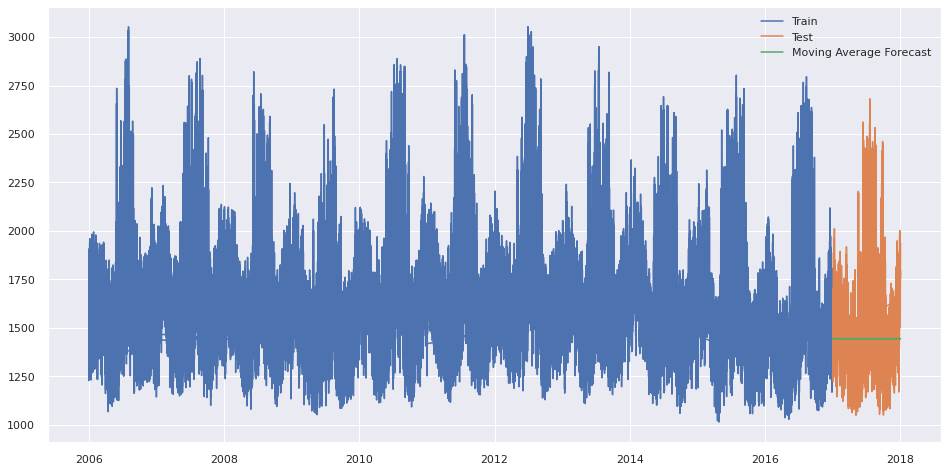

In [ ]:
# Visualization for Moving Average Forecast
y_hat = test.copy()
y_hat['moving_avg'] = train.DUQ_MW.rolling(24).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train.DUQ_MW, label='Train')
plt.plot(test.DUQ_MW, label='Test')
plt.plot(y_hat['moving_avg'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
# Estimating moving avarage forecasting
est(test.DUQ_MW, y_hat.moving_avg)

MAE =  211.58811943366067
MAPE =  12.976851236479787


Moving avarage gave only slightly smaller MAE but still forecasting is not good

## Holt Winter

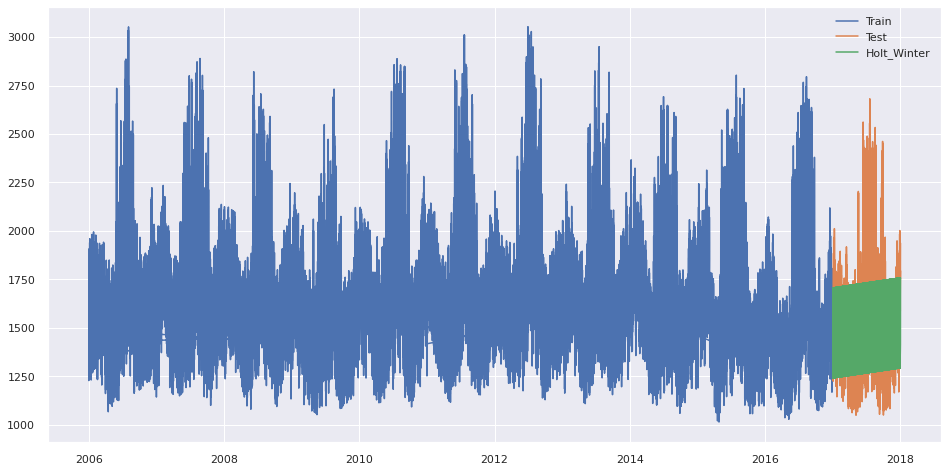

In [ ]:
# Visualization for Holt Winter forecasting
y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train.DUQ_MW) ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.DUQ_MW, label='Train')
plt.plot(test.DUQ_MW, label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [ ]:
# Estimating holt winter forecasting
est(test.DUQ_MW, y_hat.Holt_Winter)

MAE =  168.06185308414862
MAPE =  10.586620807343754


As we can see results are really better now, MAE become 168 which is lower then the first level in our task. The reason is because in Triple exponential smoothing (Holt Winter) seasonality is used as a component and for our data it results in better forecasting

#LR Baseline - raw data 
* Now I'll use simple Linear Regression model as a baseline, for that one time feature will be added - hour. 
* For cross-validation 5 TimeSeries splitting will be done. We need to use this type of split as our data in timeseries and we cannot shuffle cross-validation sets.

In [ ]:
# Adding hour feature
data['hour'] = data.index.hour

In [ ]:
# Splitting onto test and train subsets with 2017 year as splitting point
train_X, train_y, test_X, test_y = split_data(data, 'DUQ_MW', 2017)

In [ ]:
# Creating, fitting and estimating the model (with cross-validation as well)
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
y_pred_lr, res_lr = fit_est_model(lr, train_X, train_y, test_X, test_y, tscv)

MAE =  223.26329948275813
MAPE =  15.197886737712771
Mean CV score:  200.32947008536485


As we can see scores are not good, error is big, CV gave us a little bit smaller MAE, but score is even worth then for Naive forecasting 

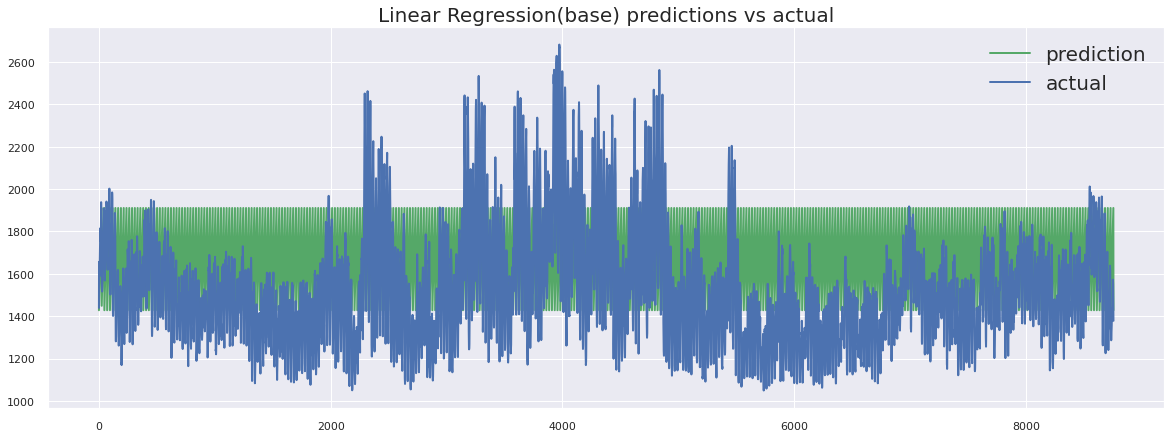

In [ ]:
# Visualization for LR baseline
plot_model(y_pred_lr, test_y, 'Linear Regression(base)')

From the plot we can see that our prediction is really bad and we need to improve our model/dataset

For checking residuals few plots and Ljung-Box test will be checked:
* Firstly residuals will be plotted to check how they are distributed around zero
* Then Autocorrelation will be checked for residuals - if autocorrelation is high then we cannot say residuals are independent and our model is not good.
* Also I've used Ljung-Box test, 4 lags were put as default there

P-values for Ljung-Box test are:
  [0. 0. 0. 0.]


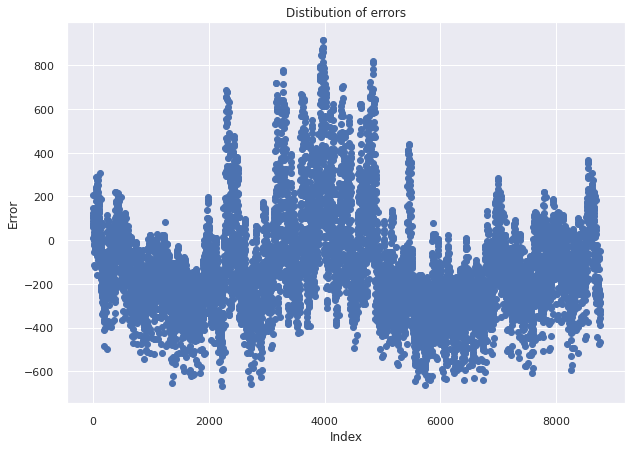

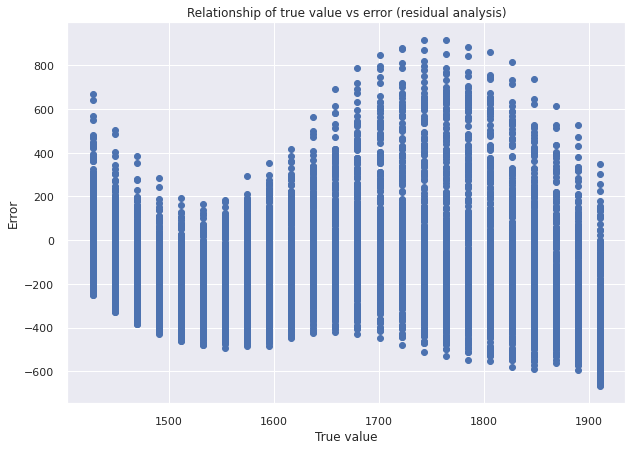

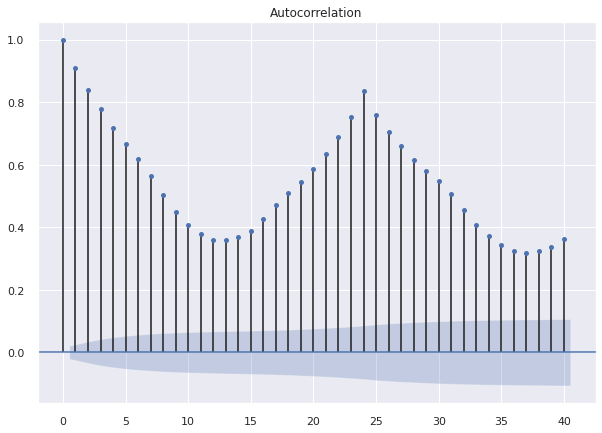

In [ ]:
# Checking residuals for LR baseline model
residual_analysis(res_lr, y_pred_lr)

From residual analysis we can see that residuals are not independent, there are not randomly distributed around zero and autocorrelation is very high between every lag of residuals. 

Also Ljung-Box test showed us p-values 0. which means we reject null hypothesis that residuals are independent and there is serial correlation of residuals. This shows that our model is not very good and we need to improve it.

# Feature engineering

While feature engineering some new features will be introduced:
* some date-related features, hour feature already exists
* lag features will be added to find out how one value of time is affected by another, range 1-7 will be added but after feature importance checking some of them can be dropped.


In [ ]:
# Copy the data and creating new date-related features
df = data.copy()
df["day"] = df.index.day
df["weekday"] = df.index.weekday
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["year"] = df.index.year
df['is_weekend'] = df.weekday.isin([5,6])*1

In [ ]:
# Adding the lag of the target variable from 1 step back up to 7
# For test dataset NaNs replaced by the mean
for i in range(1, 8):
    df["lag_{}".format(i)] = df.DUQ_MW.shift(i)
    df["lag_{}".format(i)].fillna((df["lag_{}".format(i)].mean()), inplace=True)

Small note: I'm not sure if I've added correct loop for lag feature and it can be used in forecasting, because I have test data for the year which need to be predicted but in reality there is no such data. But I found such feature engineering in the links and it was successfully used in the described project.

# EDA after adding some features

When all new features are added let's check some visualizations

## Datetime features

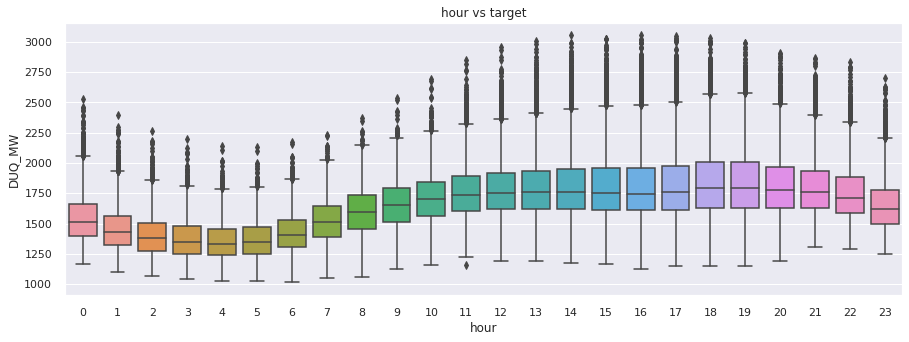

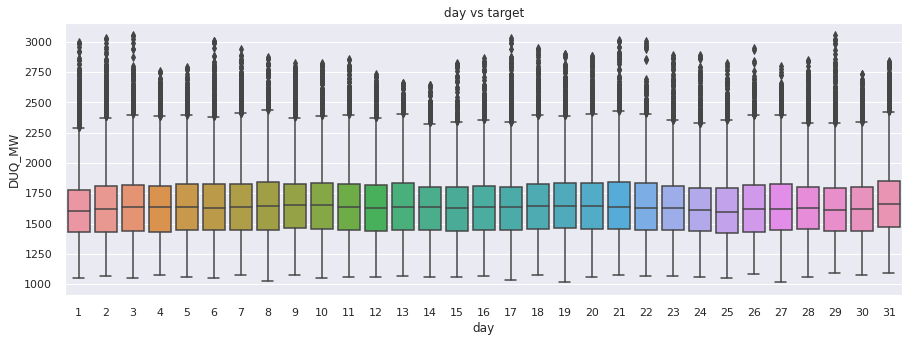

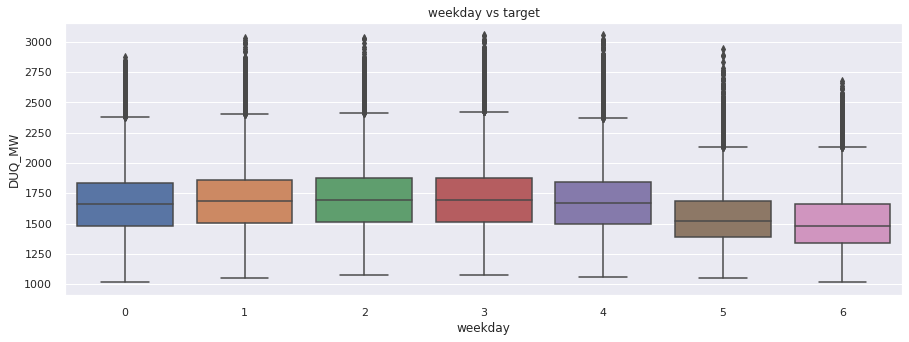

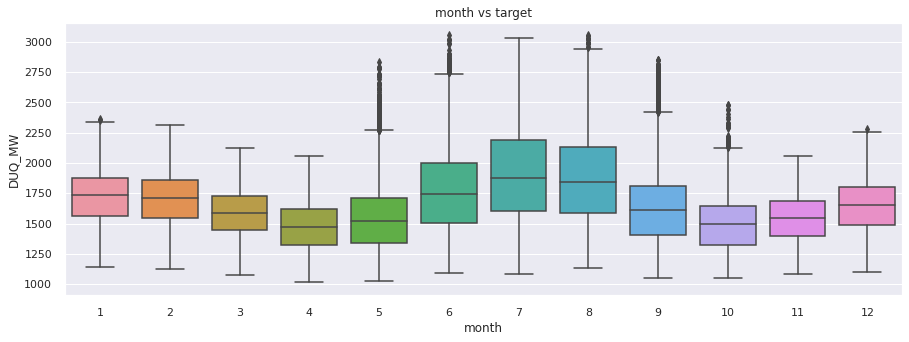

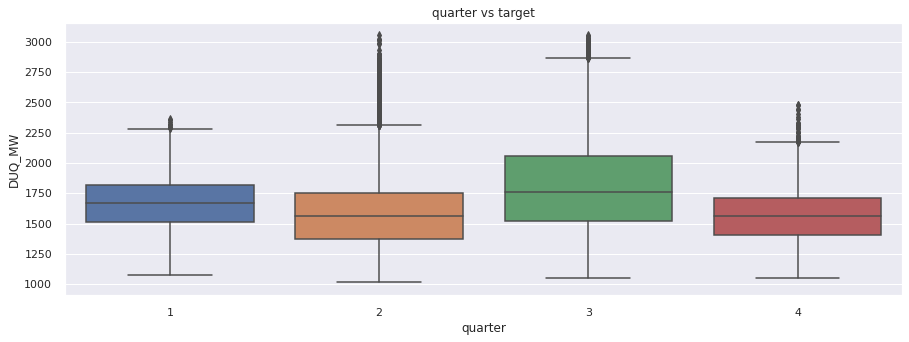

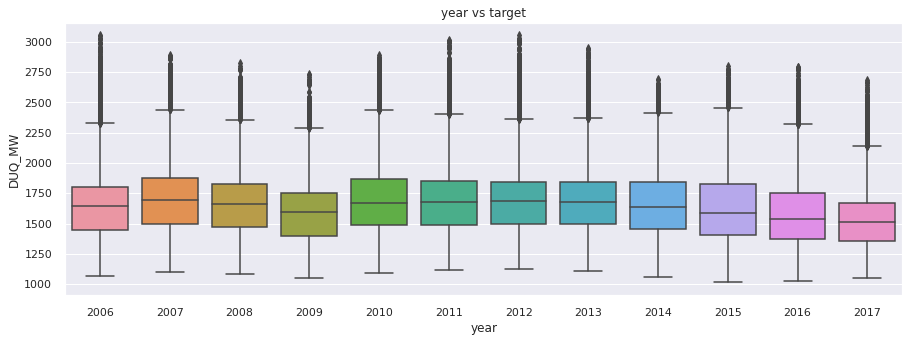

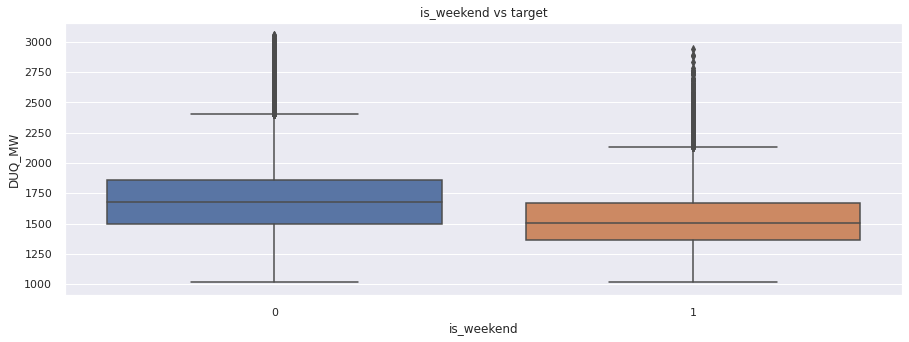

In [ ]:
# Visualization for datetime features
dt_columns = list(df.columns)[1:8]
plot_cat(df, dt_columns, df.DUQ_MW)

Here we can see next:
* Target is different for different hours of day, weekends/weekday, month/quarter and very slightly year
* Day of month almost doesn't affect target
* So most probably we have next seasonalities:
1. Daily seasonality(evening hours higher, night/morning lower)
2. Week seasonality (working day higher, weekend lower)
3. Quarter/month seasonality (summer the highest, winter smaller peak, spring/autumn lower)
* As a trend year is considered, but most probably even 2 years

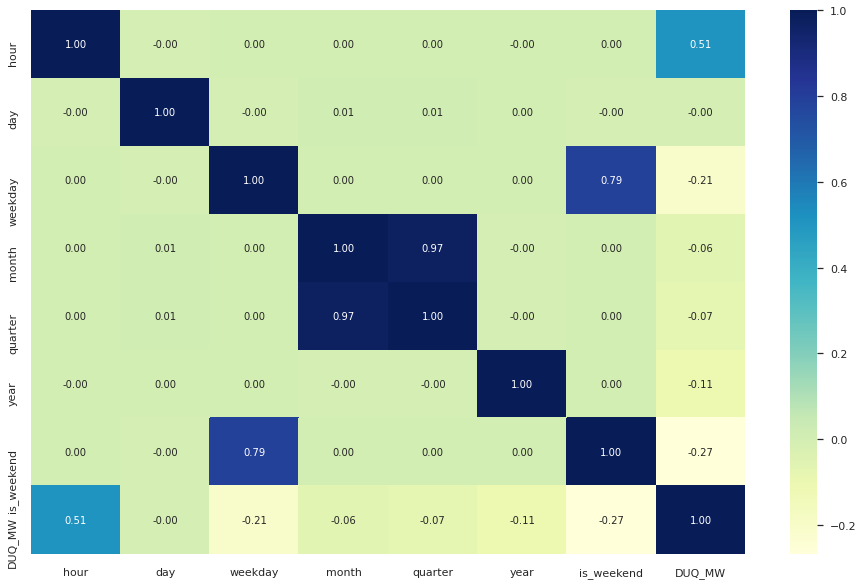

In [ ]:
# Checking correlation between datetime features - despite they are more categorical by the nature but can be assumed as ranked
dt_columns.append('DUQ_MW')
corr = df[dt_columns].corr('spearman') 
plt.figure(figsize = (16 , 10)) 
sns.heatmap(corr, annot=True, fmt='.2f', cmap="YlGnBu");

* Here Quarter and Month are highly correlated so one need to be dropped, the same for Weekday and is_weekend.
* Day has zero correlation and is just a noise, also can be dropped.

In [ ]:
# Dropping mentioned features
df.drop('day', axis=1,  inplace =True)
df.drop('month', axis=1,  inplace =True)
df.drop('weekday', axis=1,  inplace =True)

# LR after feature engineering

Now let's check the same Linear Regression model but with added features

In [ ]:
# Splitting onto test and train subsets with 2017 year as splitting point
train_X, train_y, test_X, test_y = split_data(df, 'DUQ_MW', 2017)

In [ ]:
# Fitting and estimating the model
lr_f = LinearRegression()
y_pred_lr_f, res_lr_f = fit_est_model(lr_f, train_X, train_y, test_X, test_y, tscv)

MAE =  30.51188801486967
MAPE =  2.0269456207224374
Mean CV score:  32.515863548866136


From the score and from the visualization we can see how much our model is improved. MAE from 223 become 30, MAPE decreased to 2 which is very good.

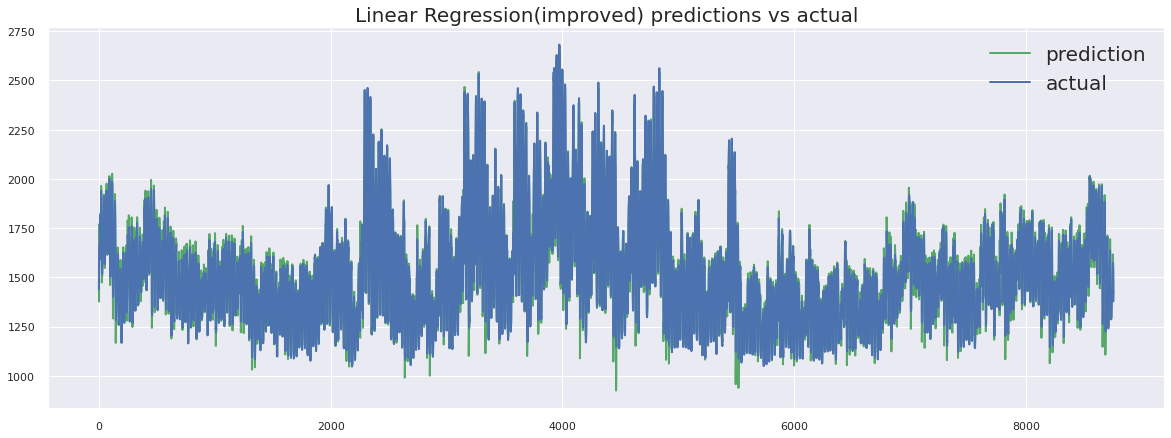

In [ ]:
# Visualization for LR improved
plot_model(y_pred_lr_f, test_y, 'Linear Regression(improved)')

P-values for Ljung-Box test are:
  [0.69184711 0.15206584 0.28240366 0.32019581]


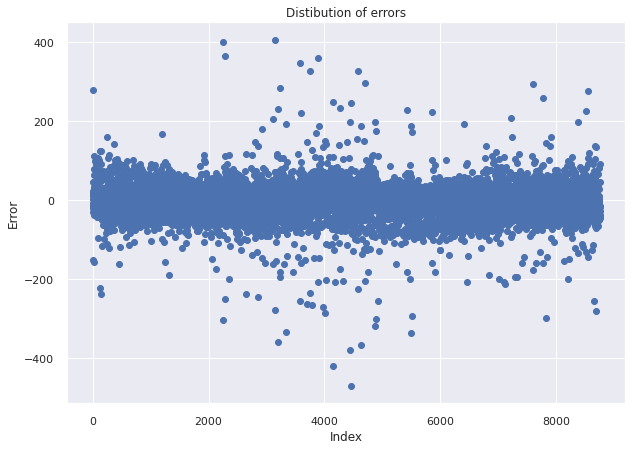

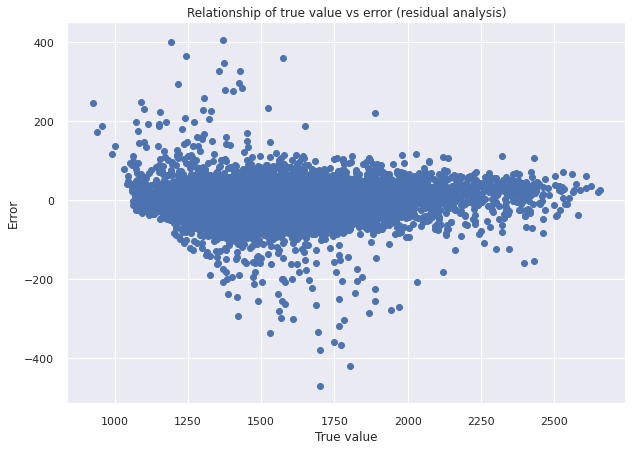

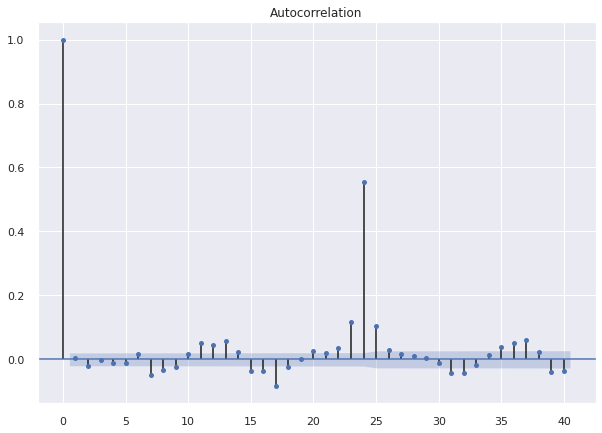

In [ ]:
# Checking residuals for LR improved model
residual_analysis(res_lr_f, y_pred_lr_f)

From residual analysis we can see that residuals are more independent,  they are more randomly distributed around zero and autocorrelation become much less.

Also Ljung-Box test showed us p-values > 0.10, which means we are not rejecting null hypothesis and residuals are independent, so this model is much better.

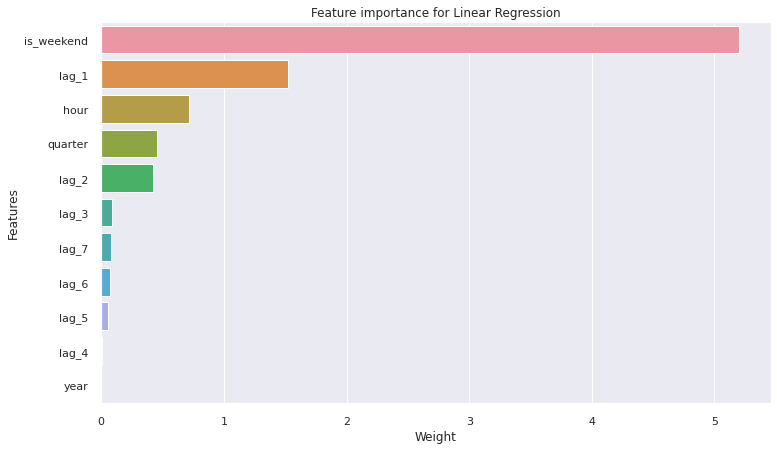

In [ ]:
# Feature importance visualization
plot_importance(lr_f, list(train_X.columns), 'Linear Regression')

Feature importance just confirmed our conclusions after EDA and is_weekend, hour, quarter and 1, 2 lags are the most important features

# Forecasting for smaller periods

Now let's check how differs MAE depending on how far we predict (horizon of prediction): 1 month ahead, 1 week ahead.

In [ ]:
# Changing test data to have only one month data forward
test_X_m, test_y_m = test_X.loc[test_X.index.month == 1], test_y.loc[test_y.index.month == 1]

In [ ]:
# Fitting and estimating the model
lr_f = LinearRegression()
y_pred_lr_f, res_lr_f = fit_est_model(lr_f, train_X, train_y, test_X_m, test_y_m, tscv)

MAE =  29.118830918641954
MAPE =  1.8998795304356293
Mean CV score:  32.58674301241126


In [ ]:
# Changing test data to have only one week data forward
test_X_w, test_y_w = test_X.loc[test_X.index.day <=7 ], test_y.loc[test_y.index.day <=7]

In [ ]:
# Fitting and estimating the model
lr_f = LinearRegression()
y_pred_lr_f, res_lr_f = fit_est_model(lr_f, train_X, train_y, test_X_w, test_y_w, tscv)

MAE =  29.604910749015804
MAPE =  2.0126310384887636
Mean CV score:  34.970116431934606


We can see that for prediction with smaller horizon MAE is smaller and forecasting is better

# Optional task - other models

As an optional some additional models will be checked for forecasting

## LGBMRegressor

In [ ]:
# Fitting and estimating LGBMRegressor
lgbm = LGBMRegressor(random_state=48)
y_pred_lgbm, res_lgbm = fit_est_model(lgbm, train_X, train_y, test_X, test_y, tscv)

MAE =  20.641431054011232
MAPE =  1.3579911390360109
Mean CV score:  31.210531707145293


For LGBMRegressor MAE and MAPE are smaller then for improved LR model

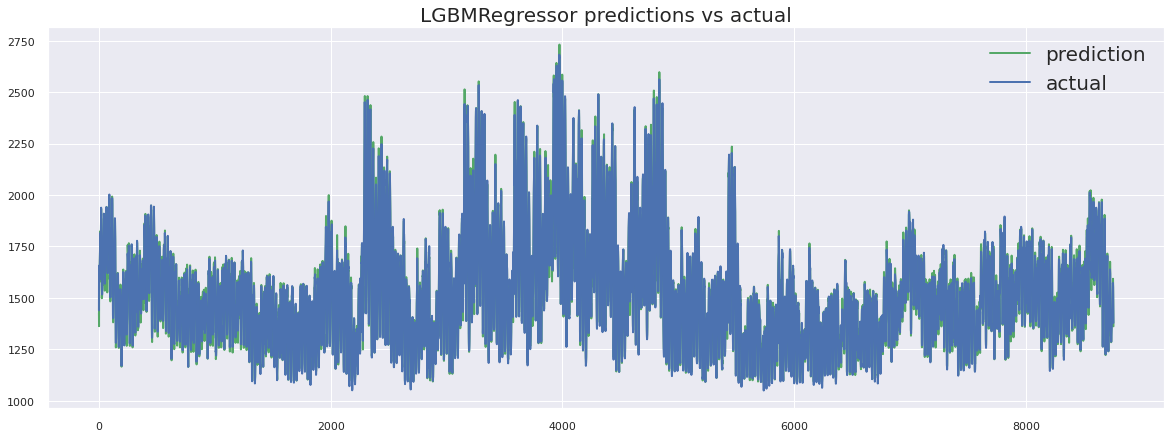

In [ ]:
# Visualization for LGBMRegressor
plot_model(y_pred_lgbm, test_y, 'LGBMRegressor')

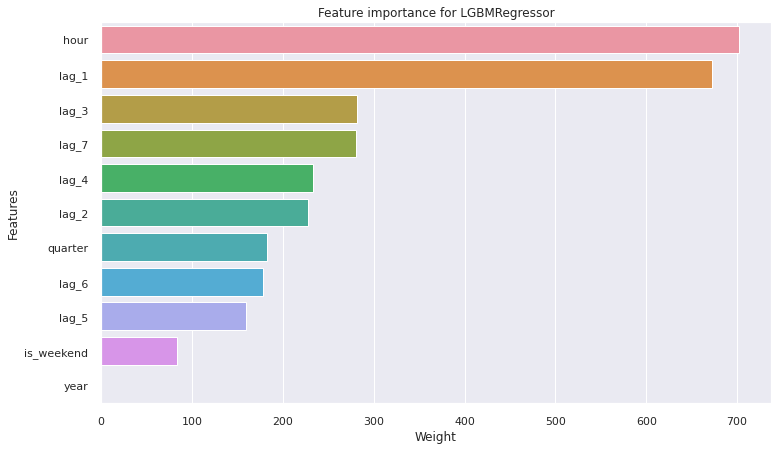

In [ ]:
# Feature importance for LGBMRegressor
plot_importance_lg(lgbm, list(train_X.columns), 'LGBMRegressor')

Feature importance is slightly different, here hour and lag 1 become the most important

P-values for Ljung-Box test are:
  [5.20173842e-39 7.56353389e-38 3.04126876e-37 3.66822503e-37]


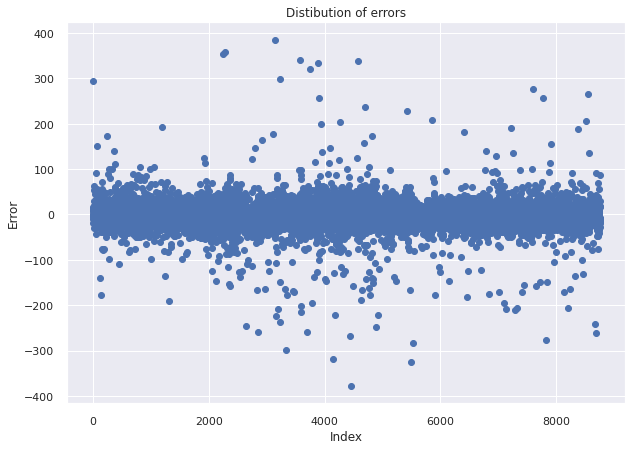

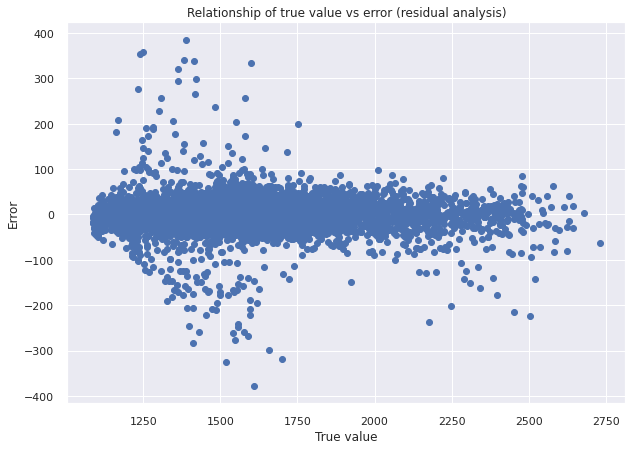

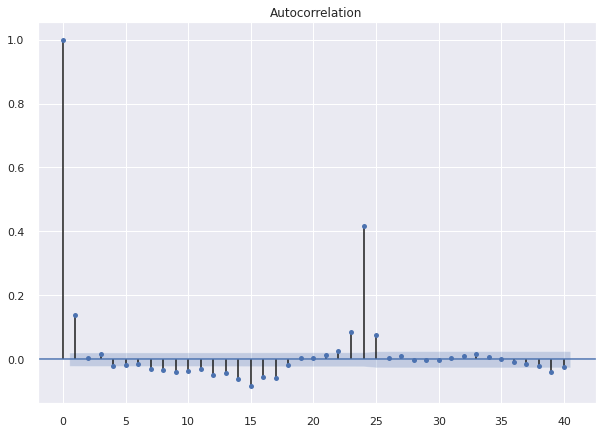

In [ ]:
# Checking residuals for LGBMRegressor
residual_analysis(res_lgbm, y_pred_lgbm)

Visualizations for the model, it's residuals and feature importance is almost the same as for LR improved model

## Stationarity

* Before using advanced models stationarity of data will be checked as most statistical models require the series to be stationary to make effective and precise predictions 
* For checking stationarity will be used visual test, Augmented Dickey Fuller test (ADF), Kwiatkowski-Phillips-Schmidt-Shin test (KPSS) and also just mean and variance of 2 parts of data set will be compared

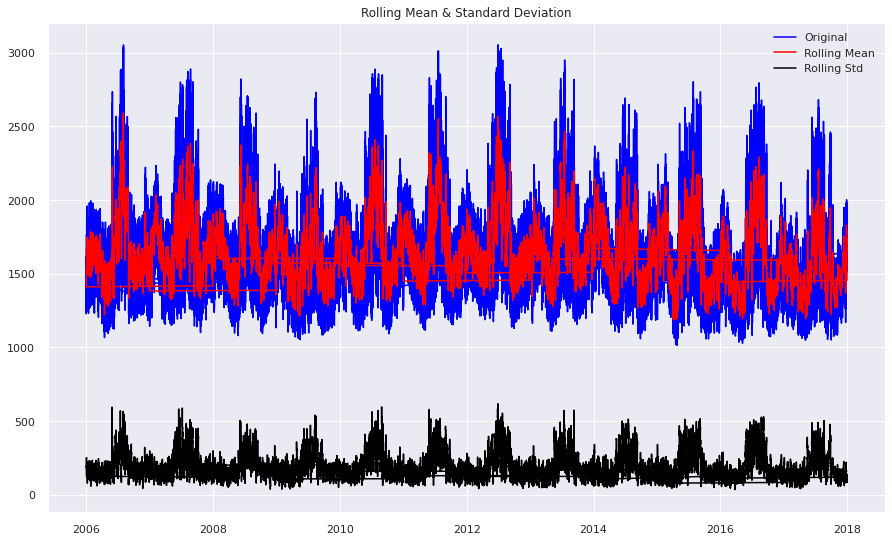


Results of Dickey-Fuller Test:
Test Statistic         -1.592200e+01
p-value                 7.904482e-29
Critical Value (1%)    -3.430412e+00
Critical Value (5%)    -2.861568e+00
Critical Value (10%)   -2.566785e+00
dtype: float64

Results of KPSS Test:
Test Statistic           3.469962
p-value                  0.010000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Statistics for 2 parts od data:

----------------------------------------------------
mean1=1676.120485
mean2=1641.319549

variance1=87809.920465
variance2=92642.001147

----------------------------------------------------


In [ ]:
# Visualization and stationarity tests for the data
test_stationarity(df.DUQ_MW, 24, df, 2012)

As we can see here visually there is variation of mean on the plot. But if to compare mean and variance of 2 big parts of data separated by 2012 year then difference is not big.

Also regarding tests: 
* For ADF test here Test Statistic is smaller then critical values and p-value is very small so we can reject null hyposesis and the series has no unit root(is stationary)
* For KPSS test here Test Statistic is bigger then critical values so the series has unit root(is not stationary)
* From our results: KPSS = not stationary and ADF = stationary, so we can try differencing to make series stationary

In [ ]:
# Calculating differencing
y_dif = df.DUQ_MW - df.DUQ_MW.shift(2)
y_dif = y_dif.dropna()
dif = pd.DataFrame(y_dif)

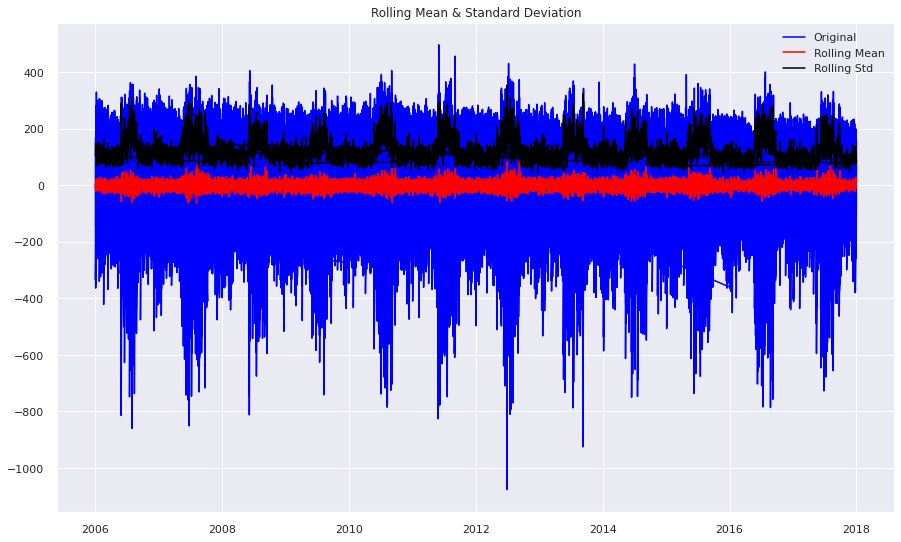


Results of Dickey-Fuller Test:
Test Statistic         -48.920764
p-value                  0.000000
Critical Value (1%)     -3.430412
Critical Value (5%)     -2.861568
Critical Value (10%)    -2.566785
dtype: float64

Results of KPSS Test:
Test Statistic           0.001541
p-value                  0.100000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Statistics for 2 parts od data:

----------------------------------------------------
mean1=0.004756
mean2=-0.004278

variance1=17262.778436
variance2=16094.090390

----------------------------------------------------


In [ ]:
# Visualization and stationarity tests for the data with differencing
test_stationarity(y_dif, 24, dif, 2012)

After differencing data become more close to stationary and both ADF and KPSS tests confirms data is stationary 

## Trend/Seasonality decompose

To use our dataset in ARIMA model we need to predict lower frequency data because memory is not enough for hourly data, so will resample the data first

In [ ]:
# Resampling data by months
data.drop('hour', axis=1, inplace=True)
data_m = data.resample("m").mean()

Now we can check trend, seasonality and residuals after decomposition

<Figure size 648x504 with 0 Axes>

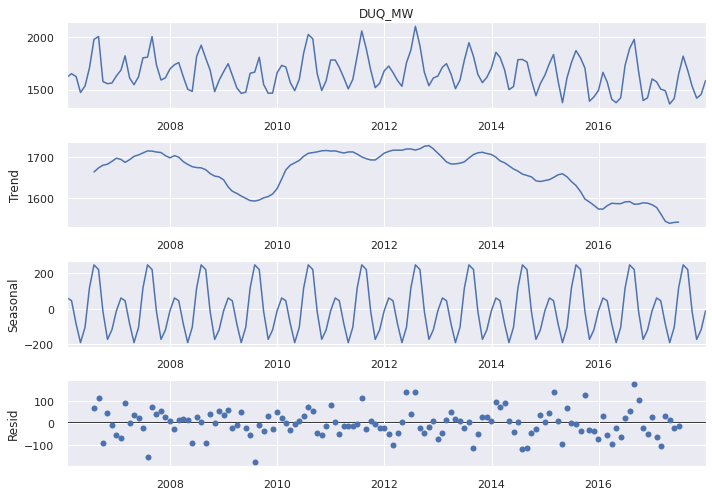

In [ ]:
# Visualization for decomposition on trend, seasonality and residuals for additive model
result = seasonal_decompose(data_m.DUQ_MW, model='additive', period=12)
plt.figure(figsize=(9, 7))
result.plot()
plt.show();

We can see here obvious seasonality(high peak in appr.7-9month and smaller peak appr.12-2month) and general trend (which shows some decreasing over years), also residuals are around zero and show some random allocation

## ARIMA

In [ ]:
# Preparing monthly data for ARIMA
train_y_a = data_m.loc[data_m.index.year < 2017]
test_y_a = data_m.loc[data_m.index.year >= 2017]
train_y_a = train_y_a.DUQ_MW
test_y_a = test_y_a.DUQ_MW

In [ ]:
# Autosearch for the best parameters for ARIMA where AIC is the smallest
model = pm.auto_arima(train_y_a, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=8, max_q=8, 
                      m=1,              
                      d=None,          
                      seasonal=True,   
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1714.320, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1670.741, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1649.882, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2336.663, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1642.396, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1605.374, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1600.011, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1599.317, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1589.741, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1589.098, Time=0.37 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=1590.757, Time=0.53 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1591.102, Time=0.59 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1591.542, Time=0.52 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=1591.980, Time=0.70 sec
 ARIMA(5,0,0)(0,0,0)[0]          

In [ ]:
# Using selected parameters in ARIMA
model = ARIMA(train_y_a, order=(5, 0, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 DUQ_MW   No. Observations:                  132
Model:                     ARMA(5, 0)   Log Likelihood                -787.537
Method:                       css-mle   S.D. of innovations             93.660
Date:                Tue, 18 May 2021   AIC                           1589.073
Time:                        22:10:01   BIC                           1609.253
Sample:                    01-31-2006   HQIC                          1597.273
                         - 12-31-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1669.1043     15.445    108.070      0.000    1638.833    1699.375
ar.L1.DUQ_MW     0.7998      0.086      9.282      0.000       0.631       0.969
ar.L2.DUQ_MW    -0.3175      0.109     -2.90

From summary we can see the smallest AIC and most of p-values are very close to 0.000.

In [ ]:
# Predicting results with ARIMA model
yhat = model_fit.predict(start=0, end=train_y_a.shape[0]-1)
yhat_test = model_fit.forecast(steps=test_y_a.shape[0])[0]

In [ ]:
# Estimating obtained results
est(test_y_a, yhat_test)

MAE =  149.04454956817813
MAPE =  9.910948745589012


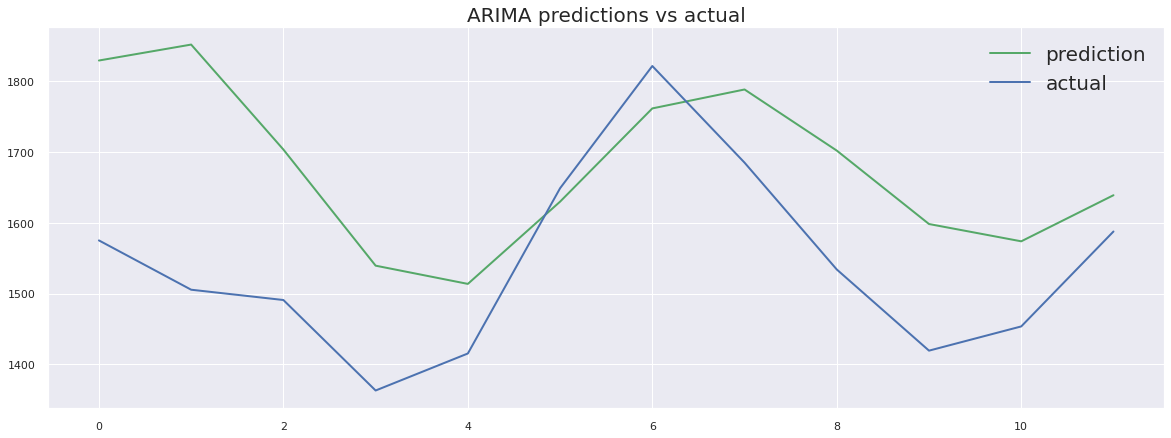

In [ ]:
# Visualization for ARIMA
plot_model(yhat_test, test_y_a, 'ARIMA')

ARIMA gave us MAE result less then 180, but not less then 140, so it can be improved with changing some hyperparameters

## Prophet

In [ ]:
# Resampling data by days for Prophet
data_d = data.resample("d").mean()
train_y = data_d.loc[data_d.index.year < 2017]
test_y = data_d.loc[data_d.index.year >= 2017]

In [ ]:
# Fitting Prophet model
y_prophet = train_y.reset_index()
y_prophet.columns = ["ds", "y"]
prophet = Prophet()
prophet.fit(y_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


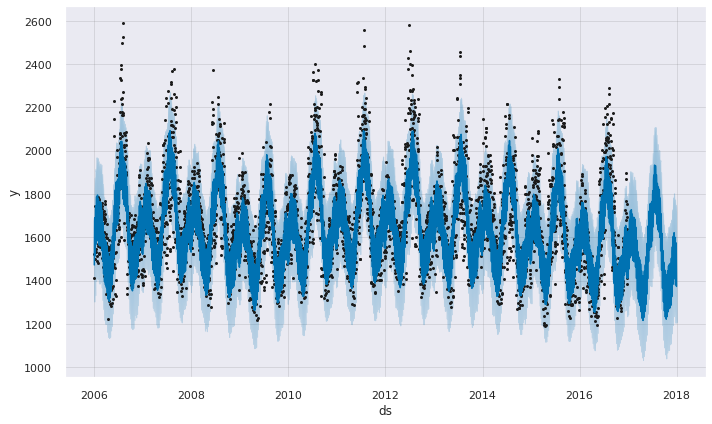

In [ ]:
# Predicting the results and visualization for them
future = prophet.make_future_dataframe(periods=365, freq='d')
fcst = prophet.predict(future)
fig = prophet.plot(fcst)

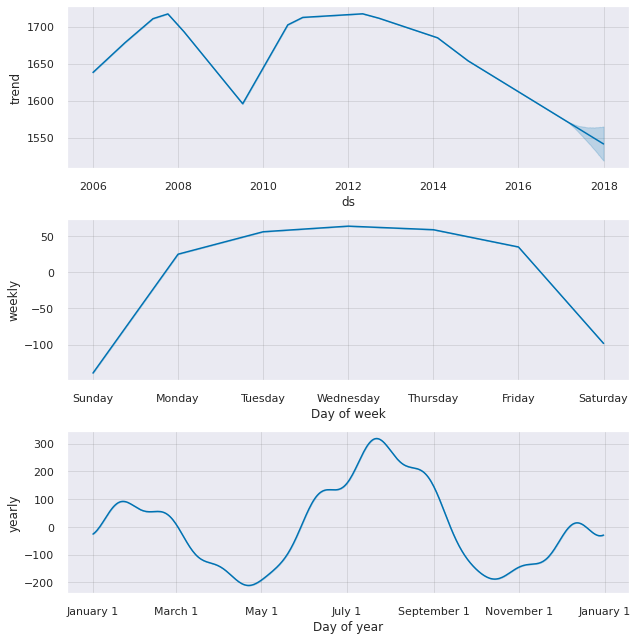

In [ ]:
# Plotting components 
fig = prophet.plot_components(fcst)

Here we can confirm already mentioned seasonalities

In [ ]:
# Setting date index to data frame with results
fcst.set_index("ds", inplace=True)

In [ ]:
# Separating predicted values
test_p = fcst.loc[fcst.index.year >= 2017]

In [ ]:
# Estimating obtained results
est_pr(test_y, test_p.yhat)

MAE =  118.42035168586382
R2 =  0.3824716046237564


As we can see Prophet gave us better result then ARIMA even for daily data, so this model is good for forecasting.

# Conclusions:
* Our data has daily, weekly and monthly seasonality and year trend 
* Several models were used for forecasting and the best one is LGBMRegressor after feature engineering and without feature engineering Prophet showed the best result. 
* For ARIMA family models we can not correctly estimate because memory doesn't allow to do hourly forecasting for big dataset
